# Lung Cancer Data

## Data cleaning

In this section I will clean up some of the obvious missing data as well as taking a quick peak at the two data sets.

In [636]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import choice
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit,train_test_split, cross_val_score
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, confusion_matrix,precision_recall_curve, roc_curve, roc_auc_score


In [637]:
clinical = pd.read_csv("clinical.csv")
genomics = pd.read_csv("genomics.csv")

In [638]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 190 non-null    int64  
 1   Outcome            190 non-null    object 
 2   Survival.Months    190 non-null    float64
 3   Age                190 non-null    int64  
 4   Grade              190 non-null    int64  
 5   Num.Primaries      190 non-null    int64  
 6   T                  190 non-null    object 
 7   N                  125 non-null    float64
 8   M                  94 non-null     float64
 9   Radiation          190 non-null    int64  
 10  Stage              190 non-null    object 
 11  Primary.Site       190 non-null    object 
 12  Histology          190 non-null    object 
 13  Tumor.Size         98 non-null     float64
 14  Num.Mutated.Genes  190 non-null    int64  
 15  Num.Mutations      190 non-null    int64  
dtypes: float64(4), int64(7), o

In [639]:
genomics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      510 non-null    int64 
 1   Gene    510 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.1+ KB


In [640]:
clinical.isnull().sum()

ID                    0
Outcome               0
Survival.Months       0
Age                   0
Grade                 0
Num.Primaries         0
T                     0
N                    65
M                    96
Radiation             0
Stage                 0
Primary.Site          0
Histology             0
Tumor.Size           92
Num.Mutated.Genes     0
Num.Mutations         0
dtype: int64

There appears to be 3 columns in the clinical data set with missing values; number of metastasis to lymph nodes "N", number of metastases "M", and Tumor size 

In [641]:
clinical["N"].value_counts(normalize=True)

2.0    0.464
0.0    0.416
1.0    0.072
3.0    0.048
Name: N, dtype: float64

There are four possible vales for "N" 0,1,2,3 with almost all values are either 0 or 2. A quick choice would be to replace the missing values with a random choice of either 0 or 2, but first let's try and see if there is any correlation between "N" and the other data. 

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_69187/2781252754.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

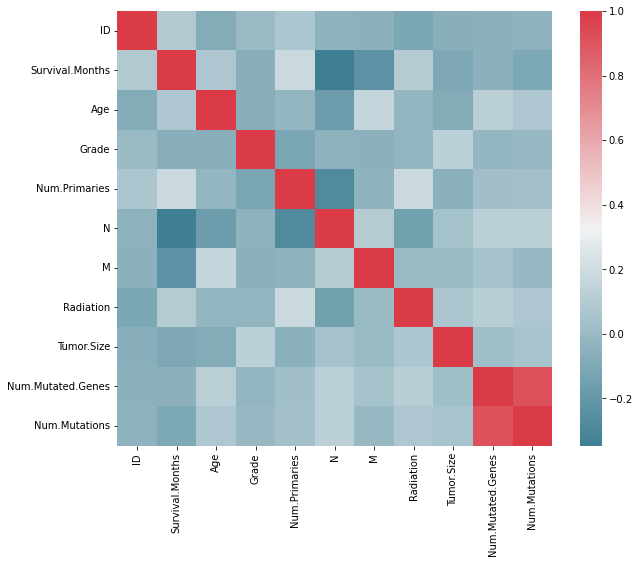

In [642]:
f, ax = plt.subplots(figsize=(10, 8))
corr = clinical.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Largely uncorrelated with the exception of number of mutated genes vs number of mutations in tumor.

In [643]:
clinical_copy = clinical.copy()

In [644]:
#clinical_copy["N"]=clinical_copy["N"].fillna(value= random.randint(0,2))
l=[0.0,1.0,2.0,3.0]
ran = choice(l,65, p=[0.416, 0.072,0.464,0.048])
c=0
for i in range(len(clinical_copy["N"])):
    if float(clinical_copy["N"].loc[i]) not in [0.0,1.0,2.0,3.0]:
        clinical_copy["N"].loc[i] = ran[c]
        c+=1

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_69187/768276878.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_copy["N"].loc[i] = ran[c]


Quick check to see how the new "filled in" data appears.

In [645]:
clinical_copy["N"].value_counts()

2.0    91
0.0    75
1.0    12
3.0    12
Name: N, dtype: int64

Another decision to consider is to replace the missing values with another index not included in "N" like -1 or 4, but I will carry on using random values chosen according to their existing probabilities, and repeat the same process with "M".

In [646]:
clinical["M"].value_counts(normalize=True)

0.0    0.914894
1.0    0.085106
Name: M, dtype: float64

In [647]:
l=[0.0,1.0]
ran = choice(l,96, p=[0.914894, 0.085106])
c=0
for i in range(len(clinical_copy["M"])):
    if clinical_copy["M"].loc[i] not in [0.0,1.0]:
        clinical_copy["M"].loc[i] = ran[c]
        c+=1

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_69187/1527952144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_copy["M"].loc[i] = ran[c]


In [648]:
clinical_copy["M"].value_counts()

0.0    174
1.0     16
Name: M, dtype: int64

In [649]:
clinical["Tumor.Size"].value_counts()

2.0     20
1.5     13
9.0     10
3.6      9
10.0     8
4.0      7
5.5      6
8.5      6
3.5      2
5.4      2
5.3      2
2.5      2
1.4      2
8.0      2
1.8      2
1.9      2
4.4      1
1.6      1
1.0      1
Name: Tumor.Size, dtype: int64

Here one might be enticed to replace with the median 3.6 which could be a reasonable choice, but numbers 3-4 only make 11 of the total entries so I will continue with the random sampling according to their existing distributions.

In [654]:
print("Median",clinical["Tumor.Size"].median())
col = "Tumor.Size"
print("Total tumor size x such that 3 < x <  4 : ",len(clinical[(clinical[col] <4 ) & (clinical[col] > 3)]))

Median 3.6
Total tumor size x such that 3 < x <  4 :  11


In [655]:
probs = list(clinical["Tumor.Size"].value_counts(normalize=True))

In [656]:
size_vals =[2.0,1.5,9.0,3.6,10.0,4.0,5.5,8.5,3.5,5.4,5.3,2.5,1.4,8.0,1.8,1.9,4.4,1.6,1.0]

In [657]:
l=size_vals
ran = choice(l,92, p=probs)
c=0
for i in range(len(clinical_copy["Tumor.Size"])):
    if clinical_copy["Tumor.Size"].loc[i] not in size_vals:
        clinical_copy["Tumor.Size"].loc[i] = ran[c]
        c+=1

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_69187/476532261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_copy["Tumor.Size"].loc[i] = ran[c]


One final nan check.

In [658]:
clinical_copy.isnull().sum()

ID                   0
Outcome              0
Survival.Months      0
Age                  0
Grade                0
Num.Primaries        0
T                    0
N                    0
M                    0
Radiation            0
Stage                0
Primary.Site         0
Histology            0
Tumor.Size           0
Num.Mutated.Genes    0
Num.Mutations        0
dtype: int64

## Data trends

In the previous section we did some quick naive cleaning according to distributions of the values that were present in the columns. That will be kept separate for now in "clinical_copy" and I will look at the raw data in this section. First we will look at the different columns against the survival result.

In [120]:
clinical["Outcome"].value_counts(normalize=True)

Dead     0.789474
Alive    0.210526
Name: Outcome, dtype: float64

We see above there is approximately 4:1 dead to survivor ratio in the data (I will sample accordingly when I separate the data into training and test sets). Below I will show the relative distributions of the average survival months and average age with respect to the deceased patients and the survivors, and we see the means and standard deviations are relatively compatible.

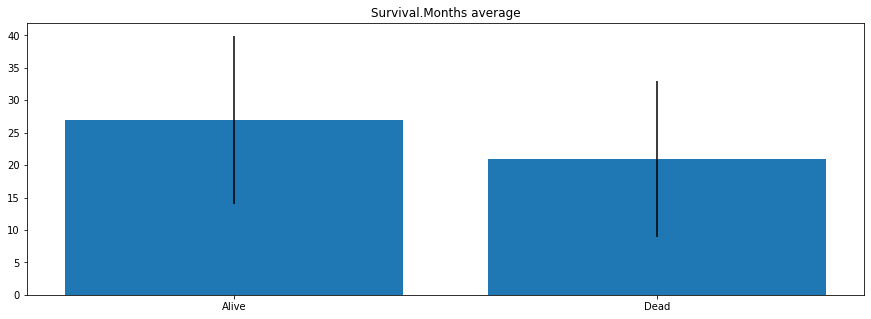

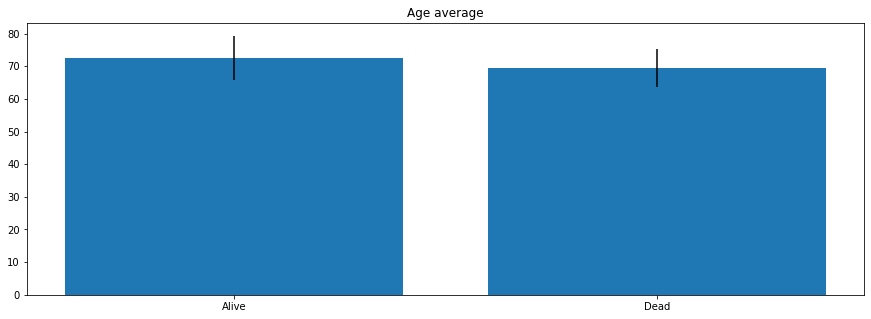

In [190]:
cols = ["Survival.Months","Age"]
for col in cols:
    plt.title(col+" average")
    plt.bar(clinical["Outcome"].unique(),
        [clinical[clinical.Outcome == "Alive"][col].mean(),
         clinical[clinical.Outcome == "Dead"][col].mean()],
       yerr =[clinical[clinical.Outcome == "Alive"][col].std(),
         clinical[clinical.Outcome == "Dead"][col].std()])
    plt.show()

Now I will go through the remaining columns separating the deceased from the survivors to see if there are any obvious trends in the data.

In [124]:
clinical["Grade"].value_counts(normalize=True)

9    0.505263
4    0.226316
2    0.152632
3    0.115789
Name: Grade, dtype: float64

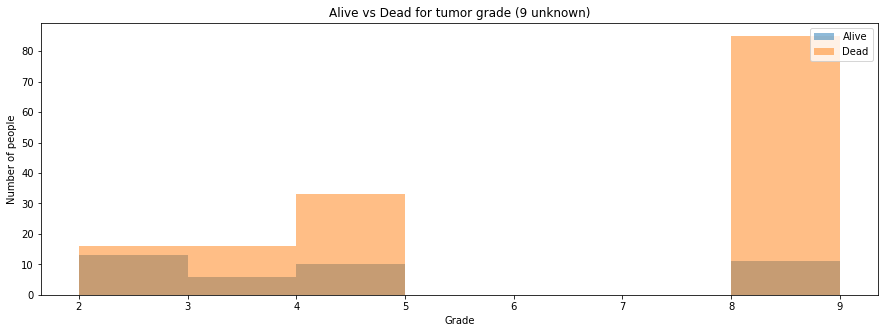

In [661]:
col = "Grade"

plt.hist(clinical[clinical.Outcome == "Alive"][col],alpha=0.5,bins=range(2,10),align="mid",label='Alive')
plt.hist(clinical[clinical.Outcome == "Dead"][col],alpha=0.5,bins=range(2,10),align="mid",label='Dead')
plt.title("Alive vs Dead for tumor grade (9 unknown)")
plt.legend(loc='upper right')
plt.ylabel("Number of people")
plt.xlabel("Grade")
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

In [182]:
ratio = len(clinical[clinical.Outcome == "Alive"])/len(clinical[clinical.Outcome == "Dead"])
print("Ratio of alive/dead:",ratio)
for val in [2.0,3.0,4.0,9.0]:
    
    print("Ratio of alive/dead for val:",val,len(clinical[(clinical.Grade==val) & (clinical.Outcome == "Alive")])/len(clinical[(clinical.Grade==val) & (clinical.Outcome == "Dead")])/ratio)


Ratio of alive/dead: 0.26666666666666666
Ratio of alive/dead for val: 2.0 3.046875
Ratio of alive/dead for val: 3.0 1.40625
Ratio of alive/dead for val: 4.0 1.1363636363636365
Ratio of alive/dead for val: 9.0 0.4852941176470589


Here I have the ratio's of alive/dead for each Grade normalized by the ratio alive/dead for the entire sample. Seems that Grade =2 has a significant deviation (about 3 times more likely survival) from the others given this data set.

In [662]:
def plot_hists(df,col):

    plt.hist(df[df.Outcome == "Alive"][col],alpha=0.5,bins=range(len(list(df[col].unique()))+1),align="mid",label='Alive')
    plt.hist(df[df.Outcome == "Dead"][col],alpha=0.5,bins=range(len(list(df[col].unique()))+1),align="mid",label='Dead')
    plt.title("Alive vs Dead for "+col)
    plt.legend(loc='upper right')
    plt.ylabel("Number of people")
    plt.xlabel(col)
    plt.show()
    plt.rcParams['figure.figsize'] = [15, 5]

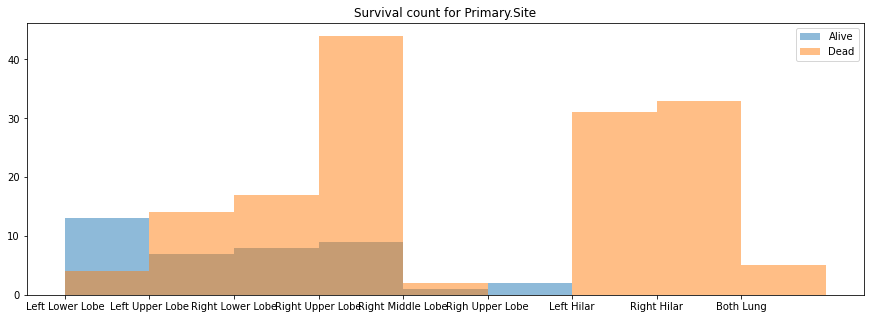

In [237]:
plot_hists(clinical,"Primary.Site")

Left lower lobe shows nice count of survival with left upper and right lower lobes not being bad. Right middle lobe and right upper lobe looks rare in general, with left and right Hilar appearing to be incredibly deadly. This column will likely be a good feature.

In [180]:
clinical["Primary.Site"].value_counts(normalize=True)

Right Upper Lobe     0.278947
Right Hilar          0.173684
Left Hilar           0.163158
Right Lower Lobe     0.131579
Left Upper Lobe      0.110526
Left Lower Lobe      0.089474
Both Lung            0.026316
Right Middle Lobe    0.015789
Righ Upper Lobe      0.010526
Name: Primary.Site, dtype: float64

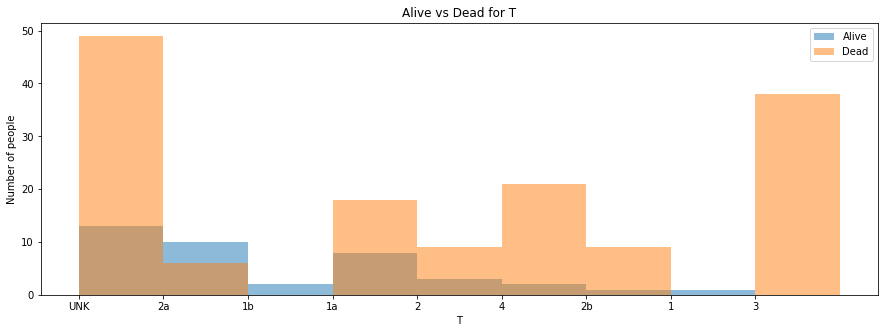

In [663]:
plot_hists(clinical,"T")

In [664]:
clinical["T"].value_counts(normalize=True)

UNK    0.326316
3      0.200000
1a     0.136842
4      0.121053
2a     0.084211
2      0.063158
2b     0.052632
1b     0.010526
1      0.005263
Name: T, dtype: float64

It appears the tumor stage at 2a could be a good indicator of survival where as 4,2b,3 likely indicate dying.

In [184]:
clinical["Histology"].value_counts(normalize=True)

Adenocarcinoma             0.452632
Squamous cell carcinoma    0.405263
Large-cell carcinoma       0.142105
Name: Histology, dtype: float64

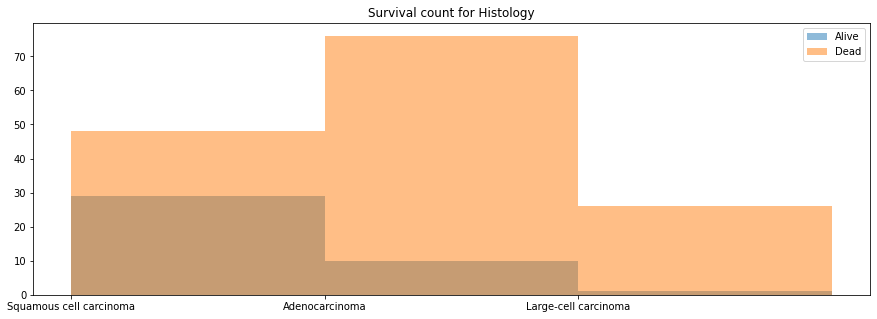

In [238]:
plot_hists(clinical,"Histology")

It appears Squamous cell carcinoma has the best chance of survival.

In [187]:
clinical["Stage"].value_counts(normalize=True)

IV      0.236842
IIIA    0.226316
IA      0.168421
IVB     0.131579
IIIB    0.126316
IIB     0.057895
IIA     0.042105
IB      0.005263
1B      0.005263
Name: Stage, dtype: float64

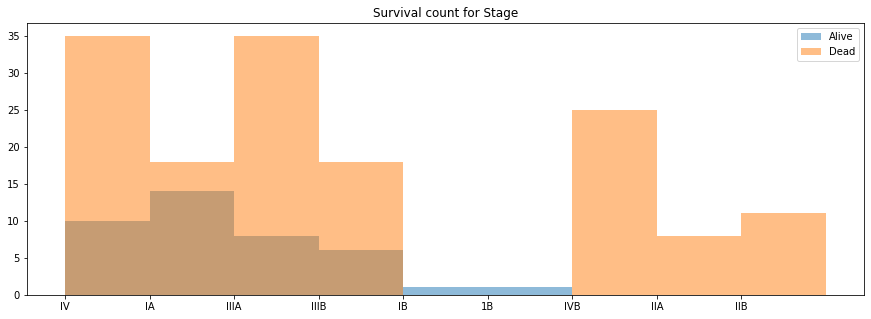

In [239]:
plot_hists(clinical,"Stage")

In [192]:
clinical["Num.Primaries"].value_counts(normalize=True)

0    0.773684
1    0.226316
Name: Num.Primaries, dtype: float64

It appears stage IA have decent survival rates and IVB,IIA,IIB all appear to be completely terminal.

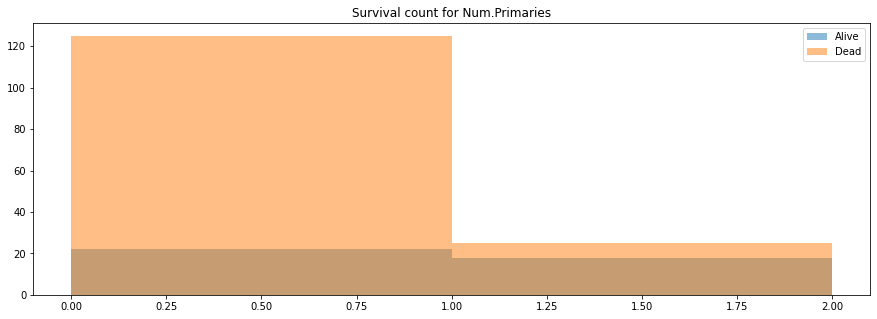

In [240]:
plot_hists(clinical,"Num.Primaries")

If the primary number is 1 there is a significant more chance of survival.

In [196]:
clinical["Radiation"]

0      0
1      5
2      0
3      0
4      0
      ..
185    0
186    0
187    0
188    0
189    0
Name: Radiation, Length: 190, dtype: int64

In [198]:
clinical["Radiation"]=clinical["Radiation"].replace(to_replace=5.0,value=1.0)

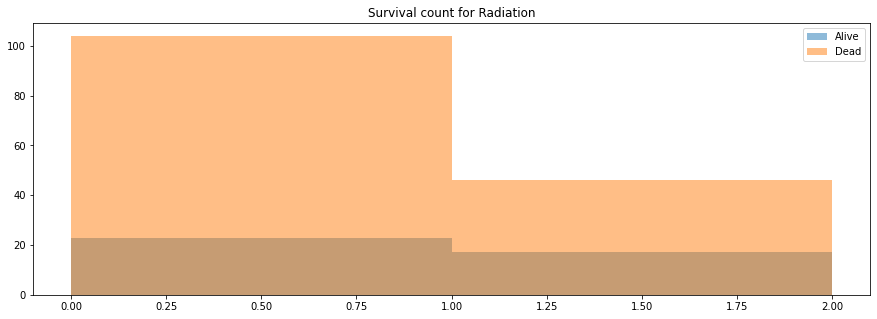

In [241]:
plot_hists(clinical,"Radiation")

Survival rate increases if radiation took place (changed "5" to "1").

In [201]:
clinical["Num.Mutations"].value_counts(normalize=True)

3    0.263158
2    0.236842
1    0.136842
5    0.131579
4    0.110526
6    0.057895
0    0.031579
8    0.015789
7    0.015789
Name: Num.Mutations, dtype: float64

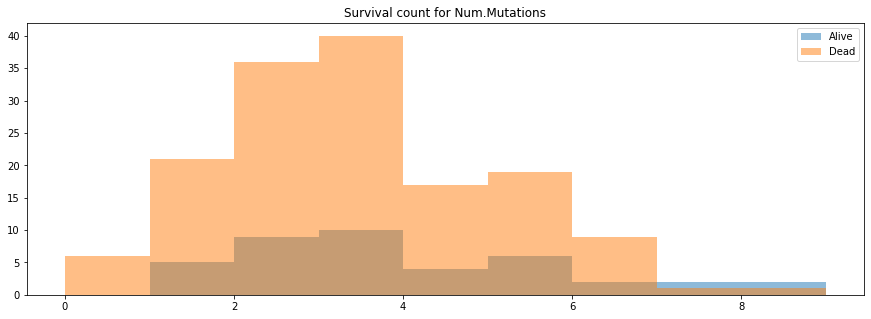

In [242]:
plot_hists(clinical,"Num.Mutations")

Semi-"normal looking" distribution.

In [205]:
clinical["Num.Mutated.Genes"].value_counts(normalize=True)

3    0.289474
2    0.278947
1    0.173684
4    0.110526
5    0.078947
0    0.031579
6    0.021053
8    0.010526
7    0.005263
Name: Num.Mutated.Genes, dtype: float64

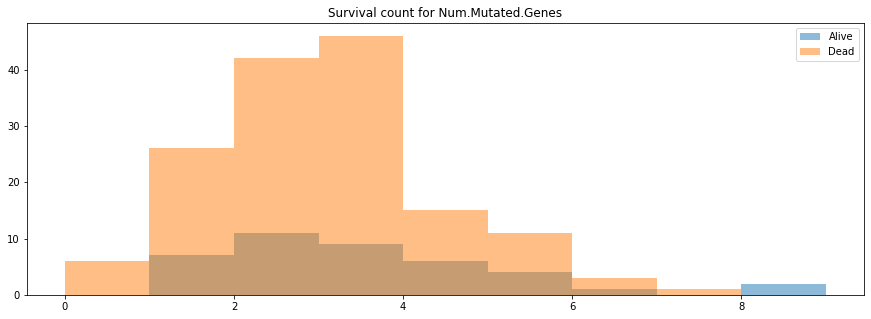

In [243]:
plot_hists(clinical,"Num.Mutated.Genes")

In [223]:
genomics["Gene"].value_counts(normalize=True)

TP53_Col1    0.229412
KRAS_Col1    0.107843
CDKN2A       0.088235
TSC2         0.060784
MSH2         0.058824
STK11        0.045098
APC          0.037255
PIK3CB       0.021569
TERT         0.019608
NF_Col2      0.019608
SMARCB1      0.017647
MET          0.017647
TP53_Col2    0.015686
FBXW7        0.015686
SMO          0.015686
NF_Col3      0.013725
GNAS         0.013725
PIK3CA       0.013725
MSH6         0.013725
NTRK1        0.013725
PTEN         0.013725
EGFR         0.011765
POLD_Col2    0.009804
NF_Col1      0.009804
PDGFRB       0.009804
RB1          0.007843
ATM_Col1     0.007843
PTCH1        0.007843
CTNNB1       0.007843
FGFR1        0.007843
NOTCH1       0.007843
DNMT3A       0.005882
CCND2        0.003922
ALK_Col2     0.003922
AKT1         0.003922
NF_Col5      0.003922
ERBB4        0.003922
ALK_Col1     0.003922
FOXL2        0.003922
FLT4         0.003922
FGFR3        0.003922
MLH_Col2     0.001961
MAP2K2       0.001961
KRAS_Col2    0.001961
HNF1A        0.001961
SMARCA4   

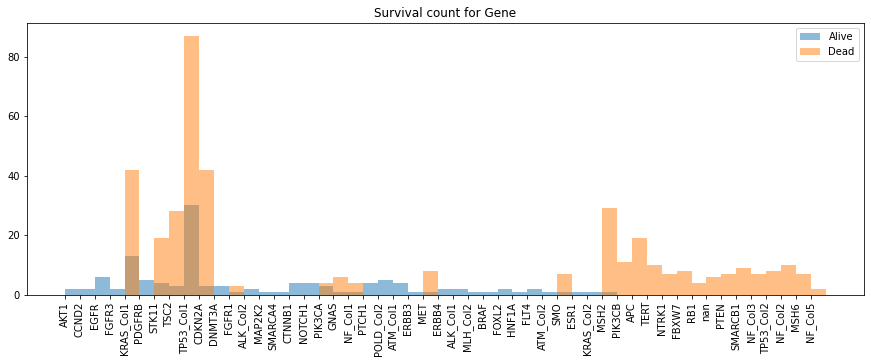

In [672]:
tmp =  pd.merge(clinical_copy,genomics,on="ID",how="left")
df = tmp
col = "Gene"
df[df.Outcome == "Dead"][col].value_counts()
plt.hist(df[df.Outcome == "Alive"][col],alpha=0.5,bins=range(len(list(df[col].unique()))+1),align="mid",label='Alive')
plt.hist(list(df[df.Outcome == "Dead"][col]),alpha=0.5,bins=range(len(list(df[col].unique()))+1),align="mid",label='Dead')
plt.title("Survival count for "+col)
plt.legend(loc='upper right')
plt.xticks(rotation=90)
plt.show()
plt.rcParams['figure.figsize'] = [15, 5]

It appears gene type can be a good feature but we will have to decide how to implement it. Now I will transform the genomics data to create features that can join the clinical data set on the ID tag in a vectorized format. I will create a column for each gene listed and if the ID contains that gene it will receive a 1, and if the gene is not present it will receive a 0 (this will also naturally take care of the IDs that do not have a gene name in the table seen in the "nan" column above).

In [441]:
gene_types = list(genomics["Gene"].unique())
columns = gene_types
columns = ["ID"]
columns+=gene_types
df = pd.DataFrame(columns = columns)

In [665]:
#print(genomics["ID"])
total = []
for i in range(1,191):
    #df["ID"] = 
    thing = [i]
    for gene_ in gene_types:
        if gene_ in list(genomics[genomics.ID==i]["Gene"]):
            thing.append( 1)
        else:
            thing.append(0)
    #print(thing)
    total.append( thing )
                

In [666]:
df = pd.DataFrame(total,columns = columns)

In [667]:
df

,ID,AKT1,ALK_Col1,ALK_Col2,APC,ATM_Col1,ATM_Col2,BRAF,CCND2,CDKN2A,...,PTEN,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2
0,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,186,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
186,187,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
187,188,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
188,189,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [668]:
data = pd.merge(clinical_copy,df,on="ID",how="left")

In [669]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 190 non-null    int64  
 1   Outcome            190 non-null    object 
 2   Survival.Months    190 non-null    float64
 3   Age                190 non-null    int64  
 4   Grade              190 non-null    int64  
 5   Num.Primaries      190 non-null    int64  
 6   T                  190 non-null    object 
 7   N                  190 non-null    float64
 8   M                  190 non-null    float64
 9   Radiation          190 non-null    int64  
 10  Stage              190 non-null    object 
 11  Primary.Site       190 non-null    object 
 12  Histology          190 non-null    object 
 13  Tumor.Size         190 non-null    float64
 14  Num.Mutated.Genes  190 non-null    int64  
 15  Num.Mutations      190 non-null    int64  
 16  AKT1               190 non

In [274]:
for i in range(len(data["Gene"])):
    if str(data["Gene"].loc[i]) == "nan":
        data["Gene"].loc[i] = "unknown"

/var/folders/zh/dvg4994d0_v8dpj_6tb0y44r0000gn/T/ipykernel_69187/3806444317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Gene"].loc[i] = "unknown"


## Data Pipe

Now I will create a pipeline to transform the data in an easy to manipulate way, that way in principle I can easily eliminate, add, and transform features in this step.

In [673]:
data = clinical_copy.merge(df,on="ID",how="inner")
#data = clinical_copy

In addition to transforming the genomics table, let's add one more feature with the N*(M+1) product to include the number of distant mestasases with number of mestasis to lymph nodes. 

In [517]:
n_times_m = data["N"]*(data["M"]+1)
n_times_m= pd.DataFrame(data=n_times_m,columns=["NxM"])
data=data.join(n_times_m)

Finally I will create the pipeline, I include a section for standard scalar normalization, as well as a one hot encoded section for categorical-like features, while dropping the "Outcome" and "Id".

In [518]:
hot_list = ["Stage","Histology","Primary.Site","Grade","N","M","T"]
st_scal = ["Survival.Months","Age","Tumor.Size","Num.Mutations","Num.Mutated.Genes","NxM"]
#or_enc = [""]
drop = ["ID","Outcome"]
outcome = data["Outcome"]
#pipe = [('standard_scaler',StandardScaler(),st_scal),
#        ("categorical",OneHotEncoder(),hot_list),
#        ("gene",OrdinalEncoder(),or_enc),
#        ('drop','drop',drop)]

pipe = [('standard_scaler',StandardScaler(),st_scal),
        ("categorical",OneHotEncoder(),hot_list),
        ('drop','drop',drop)]

full_pipe = ColumnTransformer(pipe,remainder='passthrough')
data_trans = full_pipe.fit_transform(data)

In [523]:
data

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,...,RB1,SMARCA4,SMARCB1,SMO,STK11,TERT,TP53_Col1,TP53_Col2,TSC2,NxM
0,1,Alive,9.0,67,4,0,UNK,2.0,0.0,0,...,0,0,0,0,1,0,0,0,1,2.0
1,2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,...,0,0,0,1,0,0,1,0,0,2.0
2,3,Dead,13.0,72,3,0,2,2.0,0.0,0,...,0,0,0,0,1,0,0,0,0,2.0
3,4,Dead,15.0,69,9,1,1a,0.0,1.0,0,...,0,0,0,0,0,0,1,0,0,0.0
4,5,Dead,10.0,76,9,0,UNK,0.0,0.0,0,...,0,0,0,0,0,0,1,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,186,Dead,32.0,82,9,0,4,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0.0
186,187,Dead,10.0,62,4,0,3,2.0,0.0,0,...,0,0,0,0,0,0,0,0,1,2.0
187,188,Dead,23.0,72,3,0,3,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0.0
188,189,Dead,32.0,67,4,1,1a,2.0,0.0,0,...,0,0,0,0,0,0,1,0,0,2.0


Here I create a test and training set split according to the distribution of the dead or alive outcome.

In [677]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_ind, test_ind in split.split(data_trans,outcome):
    train_list = train_ind
    test_list = test_ind

train_data, train_result = data_trans[train_list],outcome[train_list]
test_data, test_result = data_trans[test_list],outcome[test_list]

In [678]:
def convert(set_):
    # convert outcomes to 1s and 0s
    tmp = []
    for i in range(len(set_)):
        if set_.iloc[i] == "Alive":
            tmp.append(0)
        else:
            tmp.append(1)
    return tmp
train_result , test_result= convert(train_result), convert(test_result)

# Models

In this section I will try a few different modeling while recording common binary classification metrics to evaluate their success. These models predict a probability and use a threshold to decide whether or not the patient died or lived. The confusion matrix is used to see the number of True positives and negatives as well as false positives and negatives. The recall, precision, and F1 score are used to see what this threshold dependence might be. The rate of characteristic curve is also used to see the models false positive to true positive rate changes with threshold.

In [679]:
def plot_confusion(model):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("Train")
    ax2.set_title("Test")
    ax1.set(xlabel='Predicted', ylabel='True')
    ax2.set(xlabel='Predicted', ylabel='True')
    sns.heatmap(confusion_matrix(train_result,model.predict(train_data)),
            xticklabels=["Alive (predicted)","Dead (predicted)"],
            yticklabels=["Alive (true)","Dead (true)"],
            annot=True,ax=ax1);
    sns.heatmap(confusion_matrix(test_result,model.predict(test_data)),
            xticklabels=["Alive (predicted)","Dead (predicted)"],
            yticklabels=["Alive (true)","Dead (true)"],
            annot=True,ax=ax2);
    
def plot_prec_recall(p,r,t):
    plt.plot(t,p[:-1],"b--",label="precision")
    plt.plot(t,r[:-1],"g-",label="recall")
    plt.legend(loc="upper left")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.show() 
def print_scores(y,y_pred):
    print("Recall:", recall_score(y,y_pred))
    print("Precision:", precision_score(y,y_pred))
    print("F1:",f1_score(y,y_pred))
    print("Accuracy:", accuracy_score(y,y_pred))
def plot_roc(fpr,tpr,thresholds):
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='ROC')
    plt.legend(loc="upper left")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()
            

## Logistic Regression

I will begin with a logistic regression model, they generally are not susceptible to over-fitting and can be more intuitive to understand the contribution of each linear coefficient in the model.

In [301]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1e4,solver='lbfgs',verbose=1)

In [521]:
log_reg.fit(train_data,train_result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           99     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05358D+02    |proj g|=  6.50000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   99     46     49      1     0     0   3.271D-04   2.986D+01
  F =   29.856098344116013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(max_iter=10000.0, verbose=1)

In [611]:
log_reg.coef_

array([[-0.39573929, -0.16381525,  0.30757532, -0.32458848, -0.05214594,
        -0.05813464, -0.51984264, -0.75238993, -0.0697965 ,  0.61491096,
         0.4594877 , -0.65086401,  0.48067764,  0.06157056,  0.3762068 ,
         0.45607237,  0.31292517, -0.76903697,  0.27255309,  0.77673608,
        -0.89528421, -0.38689011, -0.23891743,  1.09758037, -0.53543438,
         0.02076791, -0.11115076, -0.44611506,  0.00584007, -0.37712563,
         0.81736119, -0.47171156, -0.11561261,  0.1818565 ,  0.40542823,
         0.52197919, -0.52201862, -0.16912093, -0.03731262, -0.86031509,
         0.33271036, -0.57133472,  0.19443157,  0.74726192,  0.46136059,
        -0.0977205 , -0.66220147, -0.08279681, -0.24897285,  0.        ,
        -0.53239861,  0.21739107, -0.62839904, -0.01818151, -0.0697965 ,
        -0.22107741,  1.06868403, -0.22892174, -0.23866538, -0.54907495,
        -0.28968223, -0.61076988,  0.        ,  0.70774259, -0.00533306,
        -0.24897285, -0.13715406, -0.23891743, -0.1

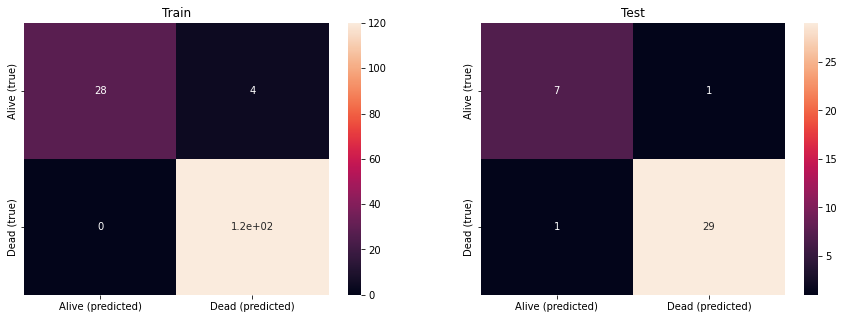

In [590]:
plot_confusion(log_reg)

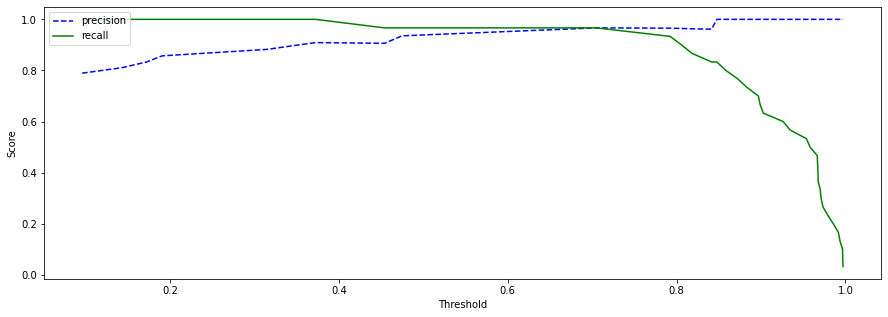

In [493]:

precision, recall, thresholds = precision_recall_curve(test_result,log_reg.predict_proba(test_data)[:,1])
plot_prec_recall(precision,recall,thresholds)

#log_reg.predict_proba(test_data)[:,1]

In [604]:
print_scores(log_reg.predict(test_data),test_result)

Recall: 0.9666666666666667
Precision: 0.9666666666666667
F1: 0.9666666666666667
Accuracy: 0.9473684210526315


In [605]:
print_scores(log_reg.predict(train_data),train_result)

Recall: 0.967741935483871
Precision: 1.0
F1: 0.9836065573770492
Accuracy: 0.9736842105263158


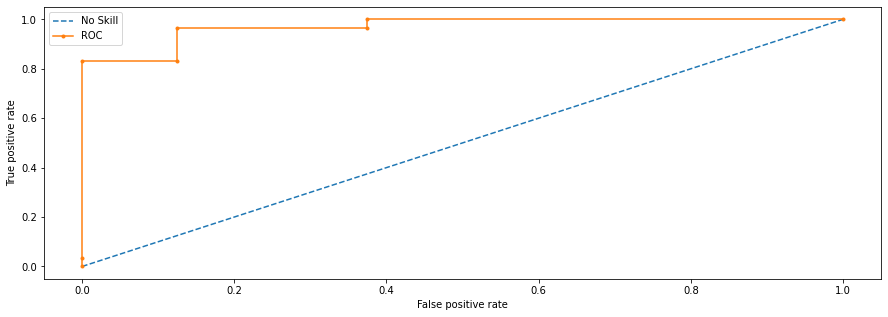

AUC: 0.9708333333333333


In [597]:
fpr, tpr, thresholds = roc_curve(test_result,log_reg.predict_proba(test_data)[:,1])
plot_roc(fpr,tpr,thresholds)
print("AUC:",roc_auc_score(test_result,log_reg.predict_proba(test_data)[:,1]))

In [524]:
cross_val_score(log_reg,train_data,train_result,scoring="accuracy",cv = 4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           99     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90188D+01    |proj g|=  6.75000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   99     41     47      1     0     0   1.561D-03   2.287D+01
  F =   22.870678858319550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           99     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.9

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


array([0.81578947, 0.84210526, 0.92105263, 0.84210526])

## Random Forest Classifier

I will now use a random forest classifier using cross validation to avoid over fitting as well as grid searching for optimal number of estimators and max features choices.

In [525]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
from sklearn.model_selection import cross_validate

param_grid = [{'n_estimators': [3,10,15,20,30,40,50,60,70], 'max_features':
  [2,4,6,8,10,15,20]},{'bootstrap':[False],'n_estimators':[3,10,15,20,30,40,50,60,70],'max_features':
  [2,3,4,6,8,10,12,14,16,18,20]},]

grid_search_rf = GridSearchCV(rf, param_grid, cv=5,scoring='accuracy',return_train_score=True)
grid_search_rf.fit(train_data,train_result)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8, 10, 15, 20],
                          'n_estimators': [3, 10, 15, 20, 30, 40, 50, 60, 70]},
                         {'bootstrap': [False],
                          'max_features': [2, 3, 4, 6, 8, 10, 12, 14, 16, 18,
                                           20],
                          'n_estimators': [3, 10, 15, 20, 30, 40, 50, 60, 70]}],
             return_train_score=True, scoring='accuracy')

In [527]:
grid_search_rf.best_params_

{'bootstrap': False, 'max_features': 12, 'n_estimators': 20}

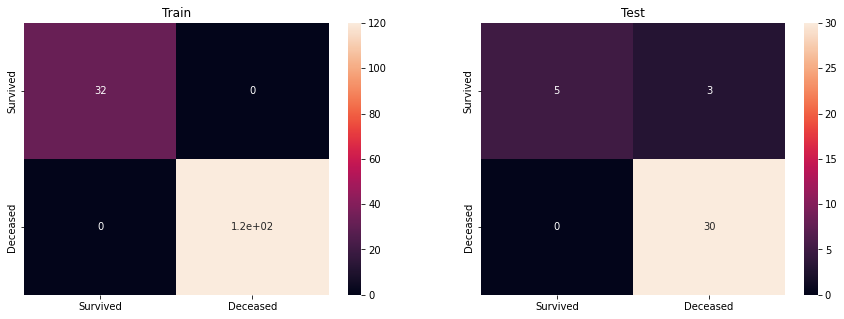

In [526]:
plot_confusion(grid_search_rf)

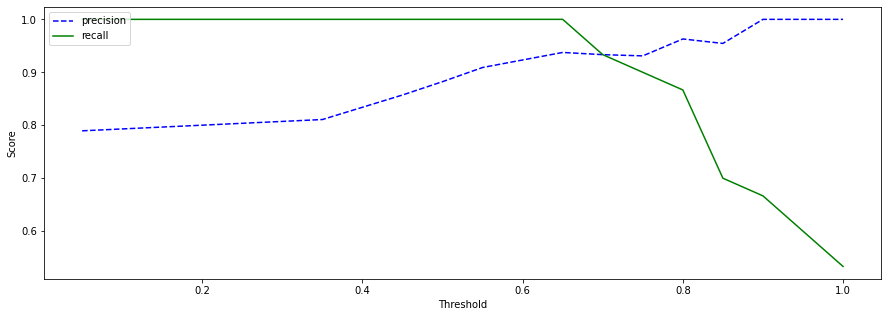

In [528]:
precision, recall, thresholds = precision_recall_curve(test_result,grid_search_rf.predict_proba(test_data)[:,1])
plot_prec_recall(precision,recall,thresholds)

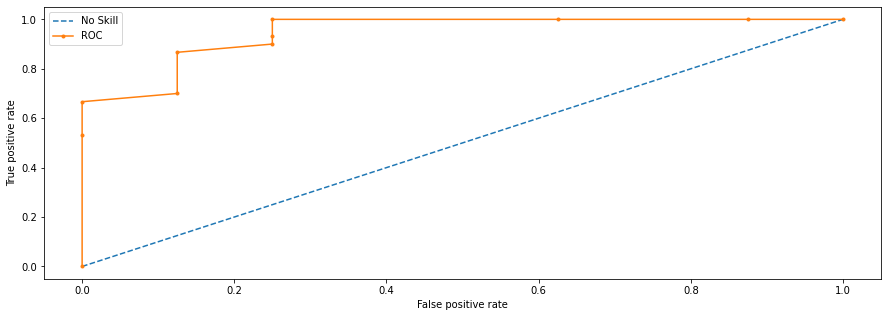

AUC: 0.9458333333333333


In [598]:
fpr, tpr, thresholds = roc_curve(test_result,grid_search_rf.predict_proba(test_data)[:,1])
plot_roc(fpr,tpr,thresholds)
print("AUC:",roc_auc_score(test_result,grid_search_rf.predict_proba(test_data)[:,1]))

In [606]:
print_scores(log_reg.predict(test_data),test_result)

Recall: 0.9666666666666667
Precision: 0.9666666666666667
F1: 0.9666666666666667
Accuracy: 0.9473684210526315


In [531]:
cross_val_score(grid_search_rf,train_data,train_result,scoring="accuracy",cv = 4)

array([0.84210526, 0.84210526, 0.94736842, 0.86842105])

## Naive Bayes

We can use naive bayes to see how well the conditional independence assumption holds. This algorithm can be simple and scalable, making it a useful starting place.

In [532]:
from sklearn.naive_bayes import GaussianNB

In [533]:
nb = GaussianNB()

In [534]:
nb.fit(train_data,train_result)

GaussianNB()

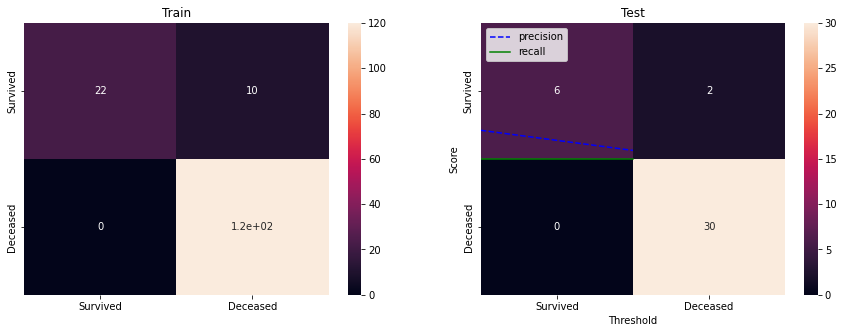

In [538]:
plot_confusion(nb)
precision, recall, thresholds = precision_recall_curve(test_result,nb.predict_proba(test_data)[:,1])
plot_prec_recall(precision,recall,thresholds)

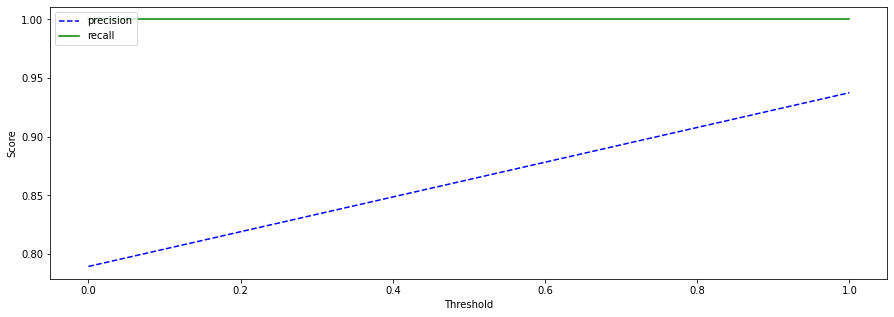

In [539]:
precision, recall, thresholds = precision_recall_curve(test_result,nb.predict_proba(test_data)[:,1])
plot_prec_recall(precision,recall,thresholds)

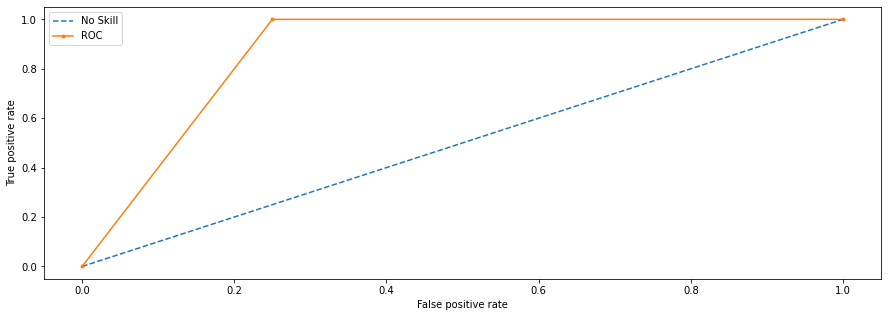

AUC: 0.875


In [599]:
fpr, tpr, thresholds = roc_curve(test_result,nb.predict_proba(test_data)[:,1])
plot_roc(fpr,tpr,thresholds)
print("AUC:",roc_auc_score(test_result,nb.predict_proba(test_data)[:,1]))

In [607]:
print_scores(nb.predict(test_data),test_result)

Recall: 0.9375
Precision: 1.0
F1: 0.967741935483871
Accuracy: 0.9473684210526315


## K nn

Implement K-nearest neighbor classifier, could be useful if data is not well modeled linearly (although it seems that it can be).

In [546]:
from sklearn.neighbors import KNeighborsClassifier
param_grid = [{'n_neighbors': range(3,10), 'weights':
  ['distance']}]

k_neigh = KNeighborsClassifier()


grid_search_knn = GridSearchCV(k_neigh, param_grid, cv=3,scoring='accuracy',return_train_score=True,refit=True)
grid_search_knn.fit(train_data,train_result)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': range(3, 10),
                          'weights': ['distance']}],
             return_train_score=True, scoring='accuracy')

In [683]:
np.floor(np.log(len(train_data))) # rule of thumb for number of neighbors

5.0

In [684]:
grid_search_knn.best_params_

{'n_neighbors': 9, 'weights': 'distance'}

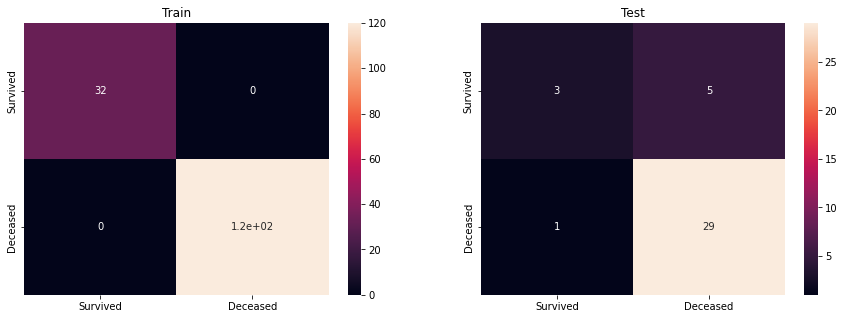

In [567]:
plot_confusion(grid_search_knn)

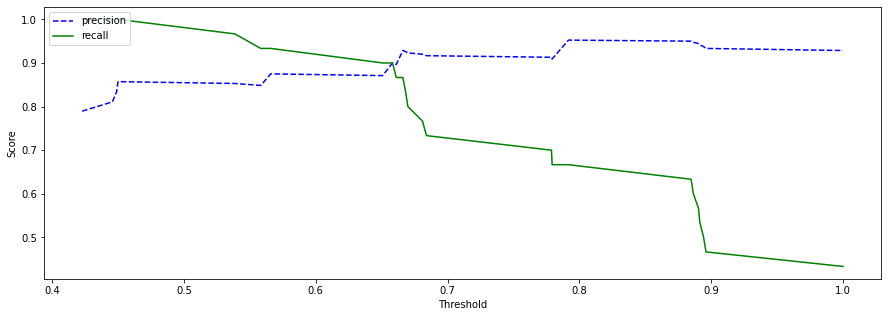

In [556]:
precision, recall, thresholds = precision_recall_curve(test_result,grid_search_knn.predict_proba(test_data)[:,1])
plot_prec_recall(precision,recall,thresholds)

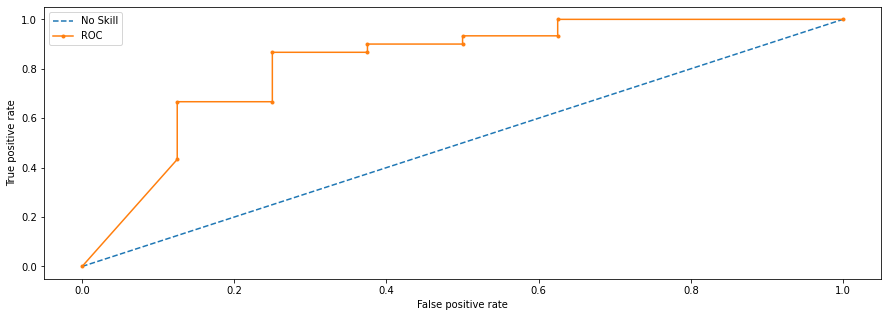

AUC: 0.8229166666666666


In [600]:
fpr, tpr, thresholds = roc_curve(test_result,grid_search_knn.predict_proba(test_data)[:,1])
plot_roc(fpr,tpr,thresholds)
print("AUC:",roc_auc_score(test_result,grid_search_knn.predict_proba(test_data)[:,1]))

In [608]:
print_scores(grid_search_knn.predict(test_data),test_result)

Recall: 0.8529411764705882
Precision: 0.9666666666666667
F1: 0.90625
Accuracy: 0.8421052631578947


## Voting Classifier

I will now employ a common ensemble method combing the all of the previous models in a soft average (combing the probabilities rather than just the "votes") leaving out the K nearest neighbors model because it seemed to perform worse than the other three.

In [551]:
from sklearn.ensemble import VotingClassifier

In [568]:
vote = VotingClassifier(voting="soft",estimators=[("lr",log_reg),("rf",grid_search_rf),("nb",nb)])


In [569]:
vote.fit(train_data,train_result)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           99     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05358D+02    |proj g|=  6.50000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   99     46     49      1     0     0   3.271D-04   2.986D+01
  F =   29.856098344116013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=10000.0, verbose=1)),
                             ('rf',
                              GridSearchCV(cv=5,
                                           estimator=RandomForestClassifier(),
                                           param_grid=[{'max_features': [2, 4,
                                                                         6, 8,
                                                                         10, 15,
                                                                         20],
                                                        'n_estimators': [3, 10,
                                                                         15, 20,
                                                                         30, 40,
                                                                         50, 60,
                                                                         70]},
                                                       {'bootstrap': [False],
                                                        'max_features': [2, 3,
                                                                         4, 6,
                                                                         8, 10,
                                                                         12, 14,
                                                                         16, 18,
                                                                         20],
                                                        'n_estimators': [3, 10,
                                                                         15, 20,
                                                                         30, 40,
                                                                         50, 60,
                                                                         70]}],
                                           return_train_score=True,
                                           scoring='accuracy')),
                             ('nb', GaussianNB())],
                 voting='soft')

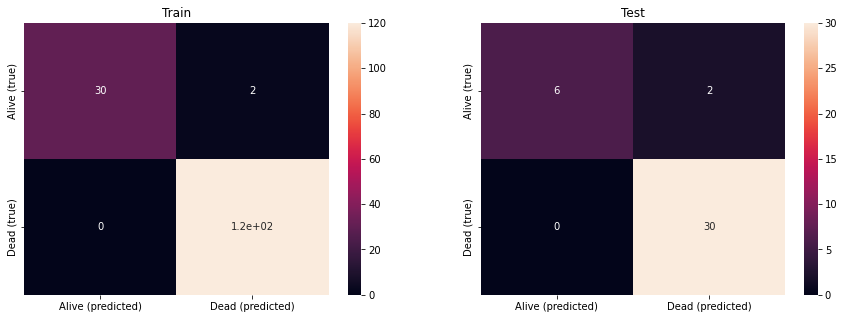

In [680]:
plot_confusion(vote)

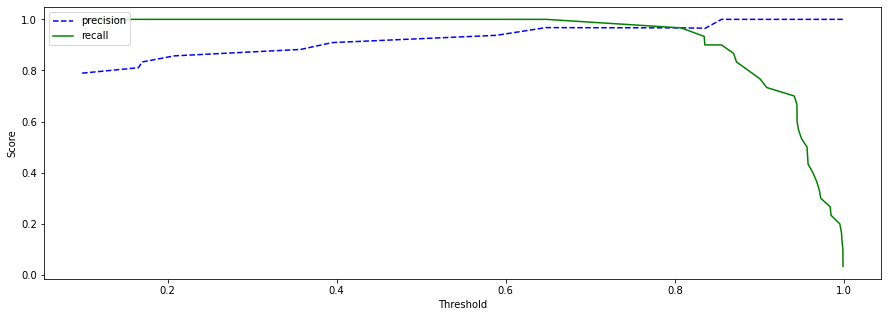

In [571]:
precision, recall, thresholds = precision_recall_curve(test_result,vote.predict_proba(test_data)[:,1])
plot_prec_recall(precision,recall,thresholds)

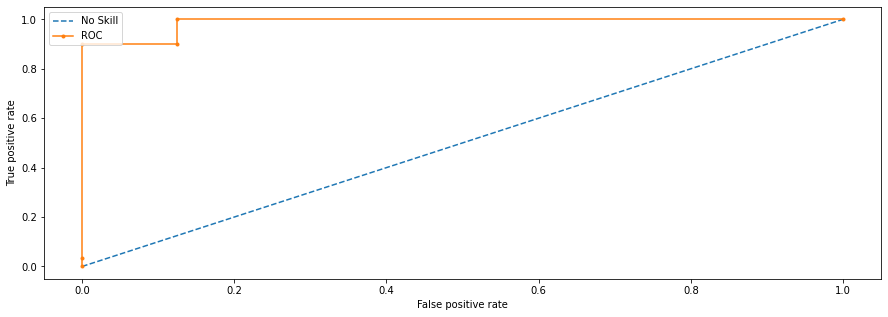

AUC: 0.9875


In [601]:
fpr, tpr, thresholds = roc_curve(test_result,vote.predict_proba(test_data)[:,1])
plot_roc(fpr,tpr,thresholds)
print("AUC:",roc_auc_score(test_result,vote.predict_proba(test_data)[:,1]))

In [609]:
print_scores(vote.predict(test_data),test_result)

Recall: 0.9375
Precision: 1.0
F1: 0.967741935483871
Accuracy: 0.9473684210526315


# Summary

I will begin by summarizing the relevant metrics I have chosen: precision, recall, accuracy, f1, and area under the roc curve, to see how each model ranked within each metric.

In [612]:
model_list = [log_reg,grid_search_rf,grid_search_knn,nb,vote]

In [619]:
prec, rec, f1, acc,auc,names = [],[],[],[],[],[]
for model in model_list:
    names.append( type(model).__name__)
    prec.append(precision_score(model.predict(test_data),test_result))
    rec.append(recall_score(model.predict(test_data),test_result))
    f1.append(f1_score(model.predict(test_data),test_result))
    acc.append(accuracy_score(model.predict(test_data),test_result))
    auc.append(roc_auc_score(model.predict(test_data),test_result))
    

In [615]:
index_ = np.argsort(prec)
print("Precision scores:")
for i in index_:
    print(prec[i],names[i])


Precision scores:
0.9666666666666667 LogisticRegression
0.9666666666666667 GridSearchCV
1.0 GridSearchCV
1.0 GaussianNB
1.0 VotingClassifier


In [616]:
index_ = np.argsort(rec)
print("Recall scores:")
for i in index_:
    print(rec[i],names[i])

Recall scores:
0.8529411764705882 GridSearchCV
0.9090909090909091 GridSearchCV
0.9375 GaussianNB
0.9375 VotingClassifier
0.9666666666666667 LogisticRegression


In [617]:
index_ = np.argsort(acc)
print("Accuracy scores:")
for i in index_:
    print(acc[i],names[i])

Accuracy scores:
0.8421052631578947 GridSearchCV
0.9210526315789473 GridSearchCV
0.9473684210526315 LogisticRegression
0.9473684210526315 GaussianNB
0.9473684210526315 VotingClassifier


In [618]:
index_ = np.argsort(f1)
print("F1 scores:")
for i in index_:
    print(f1[i],names[i])

F1 scores:
0.90625 GridSearchCV
0.9523809523809523 GridSearchCV
0.9666666666666667 LogisticRegression
0.967741935483871 GaussianNB
0.967741935483871 VotingClassifier


In [620]:
index_ = np.argsort(auc)
print("AUC ROC scores:")
for i in index_:
    print(auc[i],names[i])

AUC ROC scores:
0.801470588235294 GridSearchCV
0.9208333333333334 LogisticRegression
0.9545454545454546 GridSearchCV
0.96875 GaussianNB
0.96875 VotingClassifier


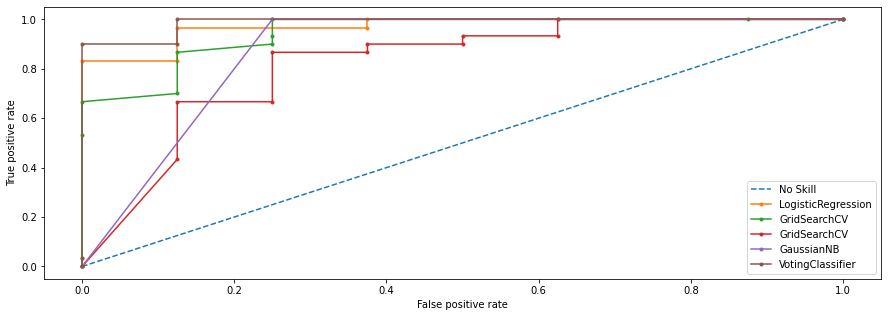

In [689]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
for i in range(len(names)):
    fpr, tpr, thresholds = roc_curve(test_result,model_list[i].predict_proba(test_data)[:,1])
    
    plt.plot(fpr, tpr, marker='.', label=names[i])
    plt.legend(loc="lower right")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
plt.show()

Judging off of these metrics and the ROC curve above, I would have to say the voting classifier is most successful with a strong case to be made for either the logistic regression or the Naive Bayes models. The voting classifier scored highest in all categories except recall, however as seen in the precision recall curves, one could tune this slightly. To speak on precision vs recall curves in the previous sections, there were so few false positives and false negatives that it did not seem worth playing with the threshold, but I note here that the threshold could be changed to get the same (or close) false positives as false negatives. 

This is mostly splitting hairs but utilizing the soft averaging of the voting algorithm if one were to expand this data set and the Naive Bayes and/or the logistic regression models begin to under perform on the training set, the benefits of the random forest interpolation power combined with the extrapolation of logistic regression can be used.

With more time I would like to play a lot more with feature creation and elimination in my pipeline I created in the end of Section 1. It did not look like age was a big feature given that most were about 70 and the standard deviation was small, so I likely could have eliminated that feature. I would like to see more data (although I do not wish lung cancer on anyone) because I feel the 190 samples might be too few. I attempted to see if there were sampling bias with cross validation scores in the various model sections and it did not seem too egregious, but I would feel more comfortable with 10x the data as received. I would like to see MRI images of the tumors so one can estimate their surface area, volume, and other size metrics. One could provide image pixel info as trainin